# G-formula: Monte Carlo Estimator
The Monte-Carlo g-formula is specifically meant to address the problem of time-varying confounding. Time-varying confounders are a particular pain for causal inference. Depending on the causal structure of the world, time-varying confounders exist as both a confounder and mediator. As such, conditional models have no solution for time-varying confounding. In 1986, James Robins proposed the brilliant idea of the Monte-Carlo g-formula as a way around this. Essentially, we use regression models to estimate the relationship between variables over time. From these regression models, we take a sample of our data from baseline and simulate their outcomes over time. The g-formula is a key link between two areas of epidemiology; mathematical modeling and phenomenological epidemiology (statistical). The g-formula has always fascinated me and I believe is the fundamental method for causal inference.

This tutorial details how to use the g-formula to estimate risks under time-varying treatment regimes. To estimate the marginal risk, we will use g-computation algorithm estimated via a Monte Carlo procedure. For a detailed introduction, please refer to the listed references.

In the following example, use a simulated data set that comes with zEpid. For our example, we are interested in the time-varying risk of death under several different treatment strategies. Specifically, our cohort is of HIV-infected individuals and we are interested in different anti-retroviral treatment (ART) strategies. First we will load the time-varying data. 

In [9]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter

from zepid import spline, load_sample_data
from zepid.graphics import dynamic_risk_plot
from zepid.causal.gformula import MonteCarloGFormula

df = load_sample_data(True)
df.info()
print(df[['id', 'enter', 'out', 'art']].head(10))

# Background variable preparations
df['lag_art'] = df['art'].shift(1)
df['lag_art'] = np.where(df.groupby('id').cumcount() == 0, 0, df['lag_art'])
df['lag_cd4'] = df['cd4'].shift(1)
df['lag_cd4'] = np.where(df.groupby('id').cumcount() == 0, df['cd40'], df['lag_cd4'])
df['lag_dvl'] = df['dvl'].shift(1)
df['lag_dvl'] = np.where(df.groupby('id').cumcount() == 0, df['dvl0'], df['lag_dvl'])
df[['age_rs0', 'age_rs1', 'age_rs2']] = spline(df, 'age0', n_knots=4, term=2, restricted=True)  # age spline
df['cd40_sq'] = df['cd40'] ** 2  # cd4 baseline cubic
df['cd40_cu'] = df['cd40'] ** 3
df['cd4_sq'] = df['cd4'] ** 2  # cd4 current cubic
df['cd4_cu'] = df['cd4'] ** 3
df['enter_sq'] = df['enter'] ** 2  # entry time cubic
df['enter_cu'] = df['enter'] ** 3

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27382 entries, 0 to 27381
Data columns (total 12 columns):
id       27382 non-null int64
enter    27382 non-null int64
out      27382 non-null float64
male     27382 non-null int64
age0     27382 non-null int64
cd40     27382 non-null int64
dvl0     27382 non-null int64
cd4      27382 non-null int64
dvl      27382 non-null int64
art      27382 non-null int64
drop     27382 non-null int64
dead     27382 non-null int64
dtypes: float64(1), int64(11)
memory usage: 2.7 MB
   id  enter   out  art
0   2      0   1.0    0
1   2      1   2.0    0
2   2      2   3.0    0
3   2      3   4.0    0
4   2      4   5.0    0
5   2      5   6.0    0
6   2      6   7.0    0
7   2      7   8.0    0
8   2      8   9.0    0
9   2      9  10.0    0


As you can see from the first few observations, the data set is set up to have multiple rows per individual. Specifically, we row corresponds to and individual over a specific period of time. For example, the first row details ID 2 for the first week (0 - 1) of follow-up. For the Monte-Carlo g-formula, the data set should be broken into these time periods. This allows us to fit successive models to estimate time-varying treatments over time. The division of rows into discrete intervals is left up to the user to decide. More finely divided levels will produce smoother risk curves, but may not be warranted based on the collected data. For our example, we are using week time-periods which will results in somewhat choppy of survival curves

Now that we have our data loaded, we will go step-by-step through the Monte Carlo g-formula. As of v0.4.3+, the Monte Carlo g-formula estimator can be implemented through the `MonteCarloGFormula` class. 

## Initializing the g-formula
To start, we initialize the `MonteCarloGFormula` class with the data set (`df`), the indicator for unique observations (`'id'`), the exposure/treatment of interest (`'art'`), the outcome of interest (`'dead'`), the starting time of the interval (`'enter'`) and the end time of the interval (`'out'`).

In [10]:
mcgf = MonteCarloGFormula(df, idvar='id', exposure='art', outcome='dead', time_in='enter', time_out='out')

## Estimating the Exposure/Treatment Model
Next we will estimate the exposure/treatment model. This model predicts when an individual receives treatment. Specfically, this model is used to model the natural course. The natural course is the observation of the world as it is. We will use the natural course predictions to see if any of our models are grossly misspecified. 

To fit the exposure model, we will call the `MonteCarloGFormula` class and specify the function `exposure_model()` to fit a model that predicts the exposure (`art`) over time. Based on substantive knowledge, we believe that ART is given based on gender, age, baseline CD4 T-cell count, current CD4 T-cell count, baseline viral load, current viral load, and time. We will model age, CD4 count, and time as cubic to impose less restrictive modeling assumptions.

Additionally, we are going to specify the optional `restriction` argument. This argument is restrict who is included in the regression model. Specifically, we will be assuming that once as individual is given ART, they remain on ART for all future follow-up visits (intent-to-treat assumption). We specify the restriction argument as `"g['lag_art']==0"`. This the `MonteCarloGFormula`, that exposure model should only be estimated to observations where the individual has not been previously treated with ART (i.e. `lag_art == 0`). This option should be used depending on your assumptions of how the natural course proceeds.  

*Note*: as you may have noticed, the `restriction` option uses `g`. This `g` is a magic-g. Inside the `MonteCarloGFormula`, it refers to the input data frame as `g`. The restriction argument uses Python's `eval()` to evaulate the input of `restriction` and other arguments. Withouth the magic-g, `MonteCarloGFormula` will NOT recognize the input as the data set. 

In [11]:
exp_m = ('male + age0 + age_rs0 + age_rs1 + age_rs2 + cd40 + cd40_sq + cd40_cu + dvl0 + '
         'cd4 + cd4_sq + cd4_cu + dvl + enter + enter_sq + enter_cu')
mcgf.exposure_model(exp_m, restriction="g['lag_art']==0")

                 Generalized Linear Model Regression Results                  
Dep. Variable:                    art   No. Observations:                 9647
Model:                            GLM   Df Residuals:                     9630
Model Family:                Binomial   Df Model:                           16
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1310.4
Date:                Sun, 31 Mar 2019   Deviance:                       2620.8
Time:                        15:40:30   Pearson chi2:                 7.71e+03
No. Iterations:                    10   Covariance Type:             nonrobust
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.8321      1.035      1.771      0.077      -0.196       3.860
male           0.3984      0.153      2.598      0.0

After fitting the above model for ART, we can see the estimate $\beta$'s from a logistic regression model. Model selection for the Monte Carlo g-formula is still an open issue, so care should be taken when deciding how to build these models. The best course of action is to make the model as flexible as possible

## Estimating the Outcome Model
The next step is to estimate the outcome model. Based on our substantive knowledge (most likely encoded through a causal graph), we believe our outcome model needs to include ART, gender, age, baseline CD4, current CD4, baseline viral load, current viral load, and time.

Again we will use the the `restriction` argument to limit what our model is fit to. Specifically, we will only fit our outcome model to individuals who were not censored during that time period (`drop == 0`). Again, we need to specify the magic-g for this to work correctly.

In [12]:
out_m = ('art + male + age0 + age_rs0 + age_rs1 + age_rs2 + cd40 + cd40_sq + cd40_cu + dvl0 + '
         'cd4 + cd4_sq + cd4_cu + dvl + enter + enter_sq + enter_cu')
mcgf.outcome_model(out_m, restriction="g['drop']==0")

                 Generalized Linear Model Regression Results                  
Dep. Variable:                   dead   No. Observations:                27333
Model:                            GLM   Df Residuals:                    27315
Model Family:                Binomial   Df Model:                           17
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -347.50
Date:                Sun, 31 Mar 2019   Deviance:                       694.99
Time:                        15:40:30   Pearson chi2:                 1.10e+04
No. Iterations:                    19   Covariance Type:             nonrobust
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -2.8777      3.025     -0.951      0.341      -8.807       3.052
art           -0.0247      0.283     -0.087      0.9

Again we see the output of the fitted logistic regression model. As mentioned before, user beware during model selection

## Time-varying Confounders
Now we are at the part where the true magic of the g-formula begins, time-varying confounders. Based on our knowledge (via a causal diagram), we believe there to be two time-varying confounders; detected viral load and CD4 T-cell count. 

### Detected Viral Load
Detectable viral load (`dvl`) is an indicator variable of whether the patient had a detectable viral load. We believe detectable viral load to be predicted by gender, age, baseline CD4, previous time-point CD4, previous ART treatment, and time.

To add time-varying confounder models, the `add_covariate_model` function is used. This function can be repeatedly called to add an arbitrary number of time-varying confounder models. The arguments we will specify are as follows; `label`, `covariate`, `model`, and `var_type`. `label` tells the Monte-Carlo procedure what order to fit the time-varying confounder models in. This is necessary since they cannot occur simultaneously in our framework. Based on our knowledge, we set detected viral load to be the first time-varying confounder to be estimated. `covariate` tells `MonteCarloGFormula` which variable we are modeling. `model` is the predictive model we are using to esitimate the `covariate`. Finally, `var_type` tells `MonteCarloGFormula` that the time-varying confounder is a binary variable. Currently only binary (logistic regression) and continuous (linear regression) time-varying confounders are supported

In [13]:
dvl_m = ('male + age0 + age_rs0 + age_rs1 + age_rs2 + cd40 + cd40_sq + cd40_cu + dvl0 + ' 
         'lag_cd4 + lag_dvl + lag_art + enter + enter_sq + enter_cu')
mcgf.add_covariate_model(label=1, covariate='dvl', model=dvl_m, var_type='binary')

                 Generalized Linear Model Regression Results                  
Dep. Variable:                    dvl   No. Observations:                27382
Model:                            GLM   Df Residuals:                    27366
Model Family:                Binomial   Df Model:                           15
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2484.3
Date:                Sun, 31 Mar 2019   Deviance:                       4968.5
Time:                        15:40:31   Pearson chi2:                 3.01e+04
No. Iterations:                     8   Covariance Type:             nonrobust
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -1.6415      0.789     -2.080      0.038      -3.188      -0.095
male           0.2029      0.110      1.843      0.0

We can see our results from the logistic regression model. We can also verify that `MonteCarloGFormula` treated `dvl` as a binary variable through this output.

### CD4 T-cell count
Our other time-varying confounder is CD4 T-cell count, a continuous variable. In our models, `cd4` is modeled as with cubic terms, so we will need to have `cd4` recoded iteratively throughout the Monte Carlo process. Additionally, there are some restrictions we need to place on this variable. Specifically, CD4 T-cell count cannot be less than 1.

Similar to detectable viral load, we will specify the `label` (this time we specify 2, so that this estimation procedure is after `dvl`), `covariate`, `model` and `var_type`. This time we specify `var_type` as continuous to estimate a linear model. 

We will now detail an additional arguments for the `add_covariate_model` function; `recode`. `recode` is used when we need to iteratively recode variables behind the scenes in the Monte Carlo procedure. The recoding is done through the Python `exec()` function. I did not intend this function to be used as part of enterprise systems, but please note that *this is a security risk if you are allowing outside users to specify this function*. This is currenltly my solution to the sheer flexibility of the g-formula. 

We need two recoding to occur. First, it is possible that the linear regression will evaluate CD4 to be less than 1, which we don't want to allow (none of our observations are below this level). Our first line in the recode scheme prevents this. It uses the magic-g and ends with a semi-colon, letting Python know that is the end of that line to execute. The next two lines were new squared and cubic terms for the predicted CD4 variables. All these recodings will be used during the Monte Carlo procedure

In [14]:
cd4_m = ('male + age0 + age_rs0 + age_rs1 + age_rs2 +  cd40 + cd40_sq + cd40_cu + dvl0 + lag_cd4 + '
         'lag_dvl + lag_art + enter + enter_sq + enter_cu')
cd4_recode_scheme = ("g['cd4'] = np.maximum(g['cd4'], 1);"
                     "g['cd4_sq'] = g['cd4']**2;"
                     "g['cd4_cu'] = g['cd4']**3")
mcgf.add_covariate_model(label=2, 
                         covariate='cd4', 
                         model=cd4_m, 
                         recode=cd4_recode_scheme, 
                         var_type='continuous')

                            GLS Regression Results                            
Dep. Variable:                    cd4   R-squared:                       0.979
Model:                            GLS   Adj. R-squared:                  0.978
Method:                 Least Squares   F-statistic:                 8.304e+04
Date:                Sun, 31 Mar 2019   Prob (F-statistic):               0.00
Time:                        15:40:31   Log-Likelihood:            -1.5467e+05
No. Observations:               27382   AIC:                         3.094e+05
Df Residuals:                   27366   BIC:                         3.095e+05
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     27.3891      7.999      3.424      0.0

## Informative Censoring
To account for informative censoring, we will specify another model. This model will predict censoring based on specified factors. For our implementation, we will assume that censoring is un-informative conditional on our set of confounders and treatment. 

In the Monte Carlo procedure, the censoring model will be predicted after the time-varying confounders, but before the outcome. Such that individuals would be censored before their outcome

In [15]:
cens_m = ("male + age0 + age_rs0 + age_rs1 + age_rs2 +  cd40 + cd40_sq + cd40_cu + dvl0 + lag_cd4 + " + 
          "lag_dvl + lag_art + enter + enter_sq + enter_cu")
mcgf.censoring_model(cens_m)

                 Generalized Linear Model Regression Results                  
Dep. Variable:         __uncensored__   No. Observations:                27382
Model:                            GLM   Df Residuals:                    27366
Model Family:                Binomial   Df Model:                           15
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -330.59
Date:                Sun, 31 Mar 2019   Deviance:                       661.19
Time:                        15:40:31   Pearson chi2:                 2.71e+04
No. Iterations:                    11   Covariance Type:             nonrobust
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      4.9528      2.632      1.882      0.060      -0.207      10.112
male          -0.1965      0.380     -0.517      0.6

Hooray! We are now through all the model fitting parts of the Monte Carlo g-formula. We are now ready to estimate the g-formula under the natural course

## Natural Course
To predict outcomes under the natural course, we will use `fit` to generate a predicted data set using Monte Carlo simulation under the designated treatment plan (the observed treatment "plan" in this case). I will explicitly lay out the Monte Carlo procedure next

In general, `MonteCarloGFormula` has a `'natural'` option to estimate the natural course. However, we will be applying the intent-to-treat assumption (once someone is given ART, they remain on ART for the rest of follow-up). So instead, we will be applying a custom treatment. This is done by specifying treatment using the magic-g specification. Specifically, we will make sure individuals have `art` set to one when their previous treatment (`lag_art`) was 1 or their current treatment was predicted to be one.

Additionally, we specify a dictionary for lagged variables. This lags variables over each time-step of the g-formula. Basically, we make sure that `art` becomes `lag_art` for the next time period.

`in_recode` recodes variables at the start. In this case, we are using it to create square and cubic terms for entrance times. 

Lastly, we can set the number of resampled (with replacement) individuals to use from our sample. This should be a high number to reduce the extent of simulation error. If we are only interested in a shorter follow-up time than the maximum follow-up time of the data set, we can set `t_max` to be a lower number

In [16]:
mcgf.fit(treatment="((g['art']==1) | (g['lag_art']==1))",
         lags={'art': 'lag_art',
               'cd4': 'lag_cd4',
               'dvl': 'lag_dvl'},
         in_recode=("g['enter_sq'] = g['enter']**2;"
                    "g['enter_cu'] = g['enter']**3"),
         sample=20000, 
         t_max=None)

Well that took a little while to run... So what was happening. Behind the scenes, `fit` was running the Monte Carlo procedure. But what does that entail?

### Monte Carlo Procedure
The following is an outline of the Monte Carlo procedure executed *for each time step*.

1) Select observations where the outcome has not happened

2) Execute any `in_recode` statements

3) Predict *each* time-varying covariates based on specified models
    - Estimate each following order they are provided. 
        - Random error is incorporated through binomial distributions or normal
    - Execute any `add_covariate_model(recode)` statements provided

4) Generate treatment values
    - Under `all` everyone is given a treatment of 1
    - Under `none` everyone is given a treatment of 0
    - Under `natural` exposures are predicted based on `exposure_model`
        - Random error is incorporated through binomial distributions
    - Under all other specifications, the treatments are 
        - predicted from `exposure_model`
        - passed through `eval()` to determine treatment

5) Predict whether indivial was censored (iff `censoring_model()` was specified)

6) Predict outcomes based on specified models and predicted covariates

7) Execute `out_recode`

8) Lag variables specified in `lags`

9) Repeat until `t_max` is hit

So, the process can be lengthy depending on the maximum time to simulate to and the number of models to predict with. 

### Natural Course Comparison
Now that we have estimate the outcomes under our natural course, we can compare this to the observed data to see if there are any gross model misspecifications. To estimate the risk functions for the natural course and the observed data, we will use the `lifelines` library and `KaplanMeierFitter`

We can access the predicted/simulated data through `MonteCarloGFormula.predicted_outcomes` after the fitting procedure is complete. Below is demonstration

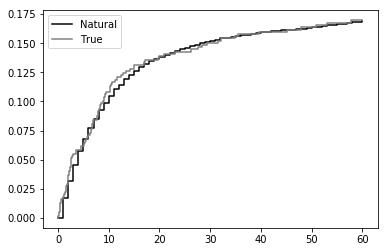

In [17]:
# Accessing predicted outcome values
gf = mcgf.predicted_outcomes
gfs = gf.loc[gf.uid_g_zepid != gf.uid_g_zepid.shift(-1)].copy()  # Only pulling out last observation for each ID

# Fitting Kaplan Meier to Natural Course
kmn = KaplanMeierFitter()
kmn.fit(durations=gfs['out'], event_observed=gfs['dead'])

# Fitting Kaplan Meier to Observed Data
kmo = KaplanMeierFitter()
kmo.fit(durations=df['out'], event_observed=df['dead'], entry=df['enter'])

# Plotting risk functions
plt.step(kmn.event_table.index, 1 - kmn.survival_function_, c='k', where='post', label='Natural')
plt.step(kmo.event_table.index, 1 - kmo.survival_function_, c='gray', where='post', label='True')
plt.legend()
plt.show()

From this we can see that out natural course predictions (black) follow the observed data pretty well (gray). *Note*: this does not mean that our models are correctly specified. *Rather it only means they may not be incorrectly specified*. Sadly, there is no way to know that all our models are correctly specified... We may take some comfort that our curves largely overlap, but do not take this for granted

## Treatment: treat-all
Now that we are happy with our natural course, we can estimate the risks under different treatment strategies. First, we will predict outcomes under the counterfactual where everyone was treated with ART at baseline. We do this by calling the `fit` function, but this time we set `treatment='all'`

In [18]:
mcgf.fit(treatment="all",
         lags={'art': 'lag_art',
               'cd4': 'lag_cd4',
               'dvl': 'lag_dvl'},
         in_recode=("g['enter_sq'] = g['enter']**2;"
                    "g['enter_cu'] = g['enter']**3"),
         sample=20000, 
         t_max=None)
g_all = mcgf.predicted_outcomes

Before visualizing, we will estimate the scenario where no one is treated

## Treatment: treat-none
Similarly, we now specify `treament='none'`

In [19]:
mcgf.fit(treatment="none",
         lags={'art': 'lag_art',
               'cd4': 'lag_cd4',
               'dvl': 'lag_dvl'},
         in_recode=("g['enter_sq'] = g['enter']**2;"
                    "g['enter_cu'] = g['enter']**3"),
         sample=20000, 
         t_max=None)
g_none = mcgf.predicted_outcomes

To compare the treatments, we will estimate the risk functions with Kaplan-Meier curves. Then we will display the risk differences over time using `dynamic_risk_plot`

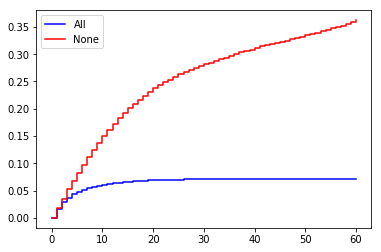

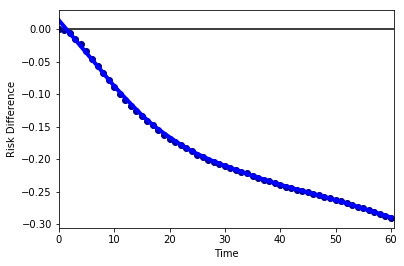

In [20]:
# Risk curve under treat-all
gfs = g_all.loc[g_all['uid_g_zepid'] != g_all['uid_g_zepid'].shift(-1)].copy()
kma = KaplanMeierFitter()
kma.fit(durations=gfs['out'], event_observed=gfs['dead'])

# Risk curve under treat-all
gfs = g_none.loc[g_none['uid_g_zepid'] != g_none['uid_g_zepid'].shift(-1)].copy()
kmn = KaplanMeierFitter()
kmn.fit(durations=gfs['out'], event_observed=gfs['dead'])

# Plotting risk functions
plt.step(kma.event_table.index, 1 - kma.survival_function_, c='blue', where='post', label='All')
plt.step(kmn.event_table.index, 1 - kmn.survival_function_, c='red', where='post', label='None')
plt.legend()
plt.show()

# Plotting Risk Difference over time
dynamic_risk_plot(1 - kma.survival_function_, 1 - kmn.survival_function_)
plt.show()

Based on our plots, we can see that the counterfactual where everyone had been treated with ART at baseline has much lower incidence of death. We can also see this in the plotted risk differences. 

## Treatment: Custom
Before ending the tutorial, let's make one final comparison. For this one, we will compare the counterfactual where we had only given ART to individuals once their CD4 T-cell count was below 200. We do this by specifying the custom treatment

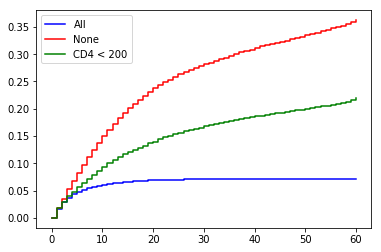

In [21]:
# Estimating risk under the custom treatment
mcgf.fit(treatment="g['cd4'] <= 200",
         lags={'art': 'lag_art',
               'cd4': 'lag_cd4',
               'dvl': 'lag_dvl'},
         in_recode=("g['enter_sq'] = g['enter']**2;"
                    "g['enter_cu'] = g['enter']**3"),
         sample=20000, 
         t_max=None)
g_cd4 = mcgf.predicted_outcomes

# Risk curve under treat-all
gfs = g_cd4.loc[g_cd4['uid_g_zepid'] != g_cd4['uid_g_zepid'].shift(-1)].copy()
kmc = KaplanMeierFitter()
kmc.fit(durations=gfs['out'], event_observed=gfs['dead'])

# Plotting risk functions
plt.step(kma.event_table.index, 1 - kma.survival_function_, c='blue', where='post', label='All')
plt.step(kmn.event_table.index, 1 - kmn.survival_function_, c='red', where='post', label='None')
plt.step(kmc.event_table.index, 1 - kmc.survival_function_, c='green', where='post', label='CD4 < 200')
plt.legend()
plt.show()

From this plot, we can see that delaying ART treatment until CD4 T-cell count is below 200 is better than the counterfactual where no one is treated with ART. However, treating everyone prevents many more deaths. Therefore, we would conclude that giving ART immediately after diagnosis should be the current practice (this is current practice due to real studies, which inspired this simulated data set).

## Confidence Intervals
One remark before closing, confidence intervals can be time consuming to calculate. Specifically, we need to use a bootstrap procedure. I will provide an example of this in a future update (specifically RD 95% CL for each time point comparing treat-all versus treat-none)

# Conclusion
Through this tutorial, I have demonstrated the usage of `MonteCarloGFormula` with *zEpid*. We want through an example of a time-varying treatment with two different time-varying confounders. For another example, please see the replication of Keil et al. 2014 using `MonteCarloGFormula`. You can follow along with the paper and the SAS code provided with the paper. Please view other tutorials for more information on functions in *zEpid*

## Further Readings
Keil, A. P., Edwards, J. K., Richardson, D. R., Naimi, A. I., & Cole, S. R. (2014). The parametric G-formula for time-to-event data: towards intuition with a worked example. Epidemiology (Cambridge, Mass.), 25(6), 889.

Westreich, D., Cole, S. R., Young, J. G., Palella, F., Tien, P. C., Kingsley, L., ... & Hernán, M. A. (2012). The parametric g‐formula to estimate the effect of highly active antiretroviral therapy on incident AIDS or death. Statistics in medicine, 31(18), 2000-2009.

Taubman, S. L., Robins, J. M., Mittleman, M. A., & Hernán, M. A. (2009). Intervening on risk factors for coronary heart disease: an application of the parametric g-formula. International journal of epidemiology, 38(6), 1599-1611.

Robins, J. (1986). A new approach to causal inference in mortality studies with a sustained exposure period—application to control of the healthy worker survivor effect. Mathematical modelling, 7(9-12), 1393-1512.